In [20]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from google.colab.patches import cv2_imshow
from skimage.transform import pyramid_reduce, resize
import zipfile
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Concatenate, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, BatchNormalization, Concatenate
from keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, Recall, BinaryIoU
from tensorflow.keras.optimizers import Adam


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
H = 256
W = 256
batch_size = 8
lr = 1e-5
epochs = 50

In [23]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path):
    images = sorted(glob(os.path.join(path, "grey", "*.bmp")))
    masks = sorted(glob(os.path.join(path, "mask", "*.bmp")))
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.1, random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [24]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [25]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [26]:
dataset_path = "/content/drive/MyDrive/Lung_Data"
create_dir("models")

# Load the dataset
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

# Create the model
model = build_unet((H, W, 3))
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

In [27]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(from_logits=False), metrics=[BinaryAccuracy(threshold=.5), Recall(thresholds=.5), BinaryIoU(threshold=.5)])

In [28]:
# callbacks
model_path = os.path.join("models", "model-{epoch:03d}-{val_loss:.4f}.h5")
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
csv_logger = CSVLogger("log.csv")
reduce_lr = ReduceLROnPlateau("val_loss", factor=0.1, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping("val_loss", patience=20, verbose=1)
tensorboard = TensorBoard(log_dir="logs")

# Create the training and validation datasets
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# Train the model
model.fit(train_dataset,
              validation_data=valid_dataset,
              epochs=epochs,
              callbacks=[checkpoint, csv_logger, reduce_lr, early_stop, tensorboard])

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.9988 - binary_accuracy: 0.2479 - recall_2: 0.9455 - binary_io_u_2: 0.1413
Epoch 1: val_loss improved from inf to 0.73293, saving model to models/model-001-0.7329.h5
22/22 [==============================] - 33s 753ms/step - loss: 0.9988 - binary_accuracy: 0.2479 - recall_2: 0.9455 - binary_io_u_2: 0.1413 - val_loss: 0.7329 - val_binary_accuracy: 0.1311 - val_recall_2: 1.0000 - val_binary_io_u_2: 0.0656 - lr: 1.0000e-05
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.7896 - binary_accuracy: 0.5319 - recall_2: 0.9907 - binary_io_u_2: 0.3306
Epoch 2: val_loss did not improve from 0.73293
22/22 [==============================] - 11s 489ms/step - loss: 0.7896 - binary_accuracy: 0.5319 - recall_2: 0.9907 - binary_io_u_2: 0.3306 - val_loss: 0.8009 - val_binary_accuracy: 0.1311 - val_recall_2: 1.0000 - val_binary_io_u_2: 0.0656 - lr: 1.0000e-05
Epoch 3/50
22/22 [==============================] - ETA: 0s 

In [29]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

# Directory for storing files
create_dir("results")



SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
       # Extracting the name
        name = x.split("/")[-1]


        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        x = image/255.0
        x = np.expand_dims(x, axis=0)


        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

# Prediction
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

# Saving the prediction
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

100%|██████████| 22/22 [00:03<00:00,  6.97it/s]


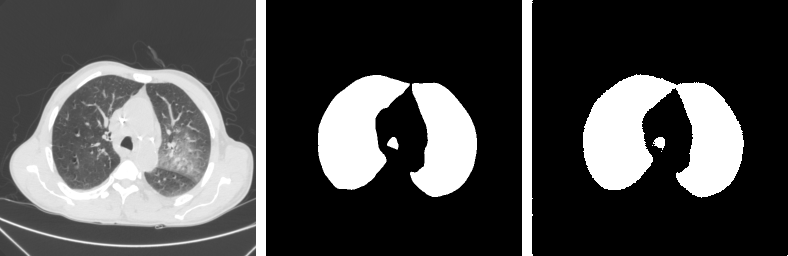

In [30]:
image = cv2.imread("/content/results/Slice.00067.bmp")
cv2_imshow(image)